In [78]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def read_excel_pandas(filename, sheet_name=0):
    try:
        df = pd.read_excel(filename, sheet_name=sheet_name)
        return df
    except FileNotFoundError:
        print(f"Error: File not found at '{filename}'")
        return None
    except ValueError as e:
        print(f"Error reading sheet '{sheet_name}': {e}")
        return None

def quartals(df):
    dates = df["DATE"]
    quarts = []
    for d in dates:
        m = d.month
        y = d.year
        if m in (1,2,3): quarts.append(f"{y}Q1")
        elif m in (4,5,6): quarts.append(f"{y}Q2")
        elif m in (7,8,9): quarts.append(f"{y}Q3")
        else: quarts.append(f"{y}Q4")
    df["Q"] = quarts
    return df

Data is gatehered from the: https://pxweb.stat.si/SiStatData/pxweb/en/Data/-/0762003S.px/table/tableViewLayout2/

We are considering only the following macro data:
* Non-performing loans: accumulated value of debtor debt which should have been paid to the bank
* Employment data
* Inflation: Harmonized inflation data for Slovenia.

Assumptions:
* Most people take loans when employed or in the case of business when they have a business plan
* Inflation

Increase in inflation -> pressure on loaner to operationalize or move things quicker. 


In [92]:
def t(df):
    df.loc["15-74 years"] = df.loc["15-74 years"].replace("-", None)
    df.loc["65 years and more"] = df.loc["65 years and more"].replace("N", None)
    return df

df_npl = pd.read_excel("datav2/npl_bank.xlsx")
df_npl["NPL_perc"] = df_npl["NPL"] * 100

df_unempl = read_excel_pandas(filename="macro.xlsx", sheet_name=0)
df_unempl = df_unempl.set_index("Unemployment")
df_unempl = t(df_unempl)

df_labour = read_excel_pandas(filename="macro.xlsx", sheet_name=1)
df_labour = df_labour.set_index("Labour in 1000")
df_labour = t(df_labour)

df_emply = read_excel_pandas(filename="macro.xlsx", sheet_name=2)
df_emply = df_emply.set_index("Employed (in 1000)")
df_emply = t(df_emply)

df_unempl = read_excel_pandas(filename="macro.xlsx", sheet_name=0)
df_unempl = df_unempl.set_index("Unemployment")
df_unempl = t(df_unempl)

df_unempl = df_unempl[df_unempl.columns].loc["TOTAL"]
df_labour = df_labour[df_labour.columns].loc["TOTAL"]
df_emply  = df_emply[df_emply.columns].loc["TOTAL"]

#########################

df_unempl2 = df_unempl.to_frame().reset_index()
df_unempl2 = df_unempl2.rename(columns={"index":"Q"})
df_unempl2 = df_unempl2.rename(columns={"TOTAL":"unemployeed"})

df_emply2 = df_emply.to_frame().reset_index()
df_emply2 = df_emply2.rename(columns={"index":"Q"})
df_emply2 = df_emply2.rename(columns={"TOTAL":"employeed"})

df_inflation = pd.read_csv("inflation.csv")
df_inflation["DATE"] = pd.to_datetime(df_inflation["DATE"])
df_inflation = quartals(df_inflation)[["Q", "HICP"]]

df = df_unempl2.merge(df_emply2, on="Q")
df = df.merge(df_inflation, on="Q")
#########################

ds = {
    "unemployed": df_unempl,
    "emply": df_emply, 
    "inflation": df_inflation
}

#### Covariance matrix
On the next chart we can see the visualization of the feature pairing and histograms. 
 

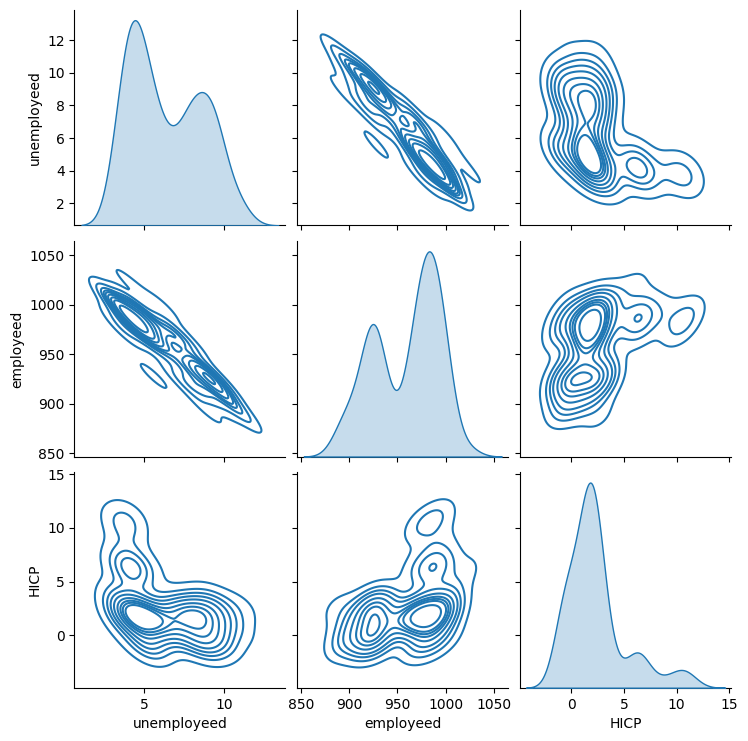

In [95]:
import seaborn as sns
#sns.set_theme(style="ticks")
sns.pairplot(df, kind="kde")

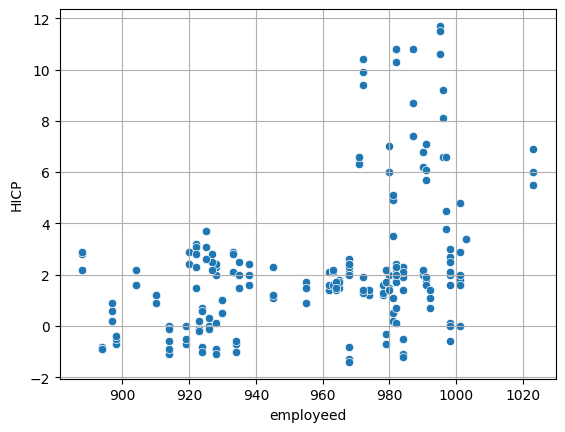

In [94]:
sns.scatterplot(x="employeed", y="HICP", data=df)
plt.grid()

As expected unemployment and employment have a negative linear relationship: 

LABOUR = UNEMPLOYMENT + EMPLOYEMENT -> UNEMPLOYMENT ~ -EMPLOYEMENT

We can see an interesting nonlinear bimodal distribution between harmonized inflation and employment/unemployment. 
It is tough to say how these two behave because. 



In [89]:
df.head()

,Q,TOTAL_U,TOTAL_E,HICP
0,2008Q1,5.1,971,6.4
1,2008Q1,5.1,971,6.3
2,2008Q1,5.1,971,6.6
3,2008Q2,4.2,990,6.2
4,2008Q2,4.2,990,6.2


E[UNEMP] = 6399.999999999994 E[EMP] = 959014.7058823529
Mean = 0.025, Std = 0.019, L = 60


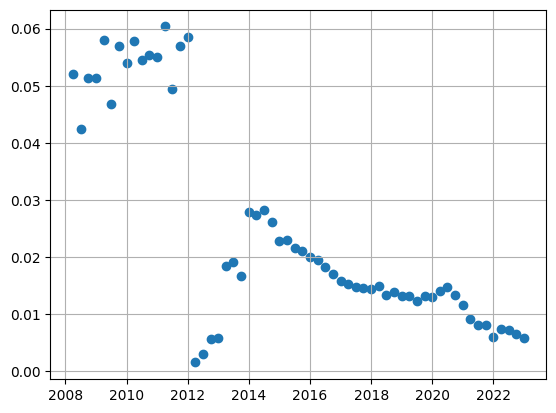

In [96]:
M1 = df.unemployeed.mean()
M2 = df.employeed.mean()
print(f"E[UNEMP] = {M1*10**3}", f"E[EMP] = {M2*10**3}")

plt.scatter(x=df_npl["DATE"], y=df_npl["NPL"])
plt.grid(True)

def variance(df):
    m = round(df["NPL"].mean(), 3)
    s = round(df["NPL"].std(), 3)
    print(f"Mean = {m}, Std = {s}, L = {len(df)}")

variance(df_npl)

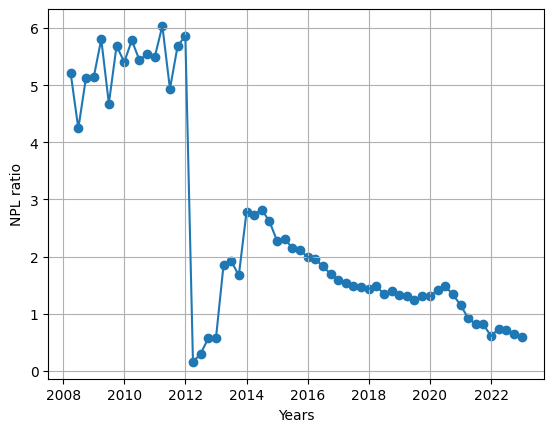

In [97]:
plt.scatter(x=df_npl["DATE"], y=df_npl["NPL_perc"])
plt.plot(df_npl["DATE"], df_npl["NPL_perc"])
plt.grid(True)
_=plt.xlabel("Years")
_=plt.ylabel("NPL ratio")

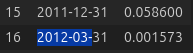 

According to our version of data, between the following dates, we can see a large deviation or spread where the NPL rate dropped considerably. 
According to the sources, the 2012 in Slovenia was remembered as the banking crisis era. 


In 2012, a banking crisis occurred in Slovenia where some banks 

Important events:
* in 2013 Slovenia granted NLB 2.321 billion EUR approved by the European Commission to NLB. 
* Privatization of the bank where dual listing on Ljubljana and London stock exchange were sold. 

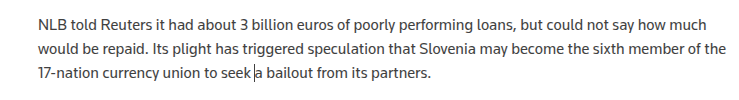

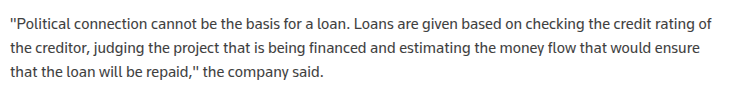

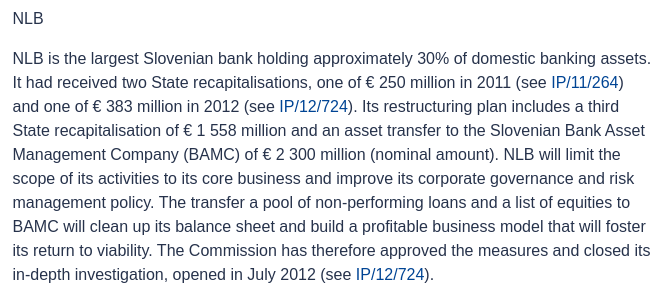

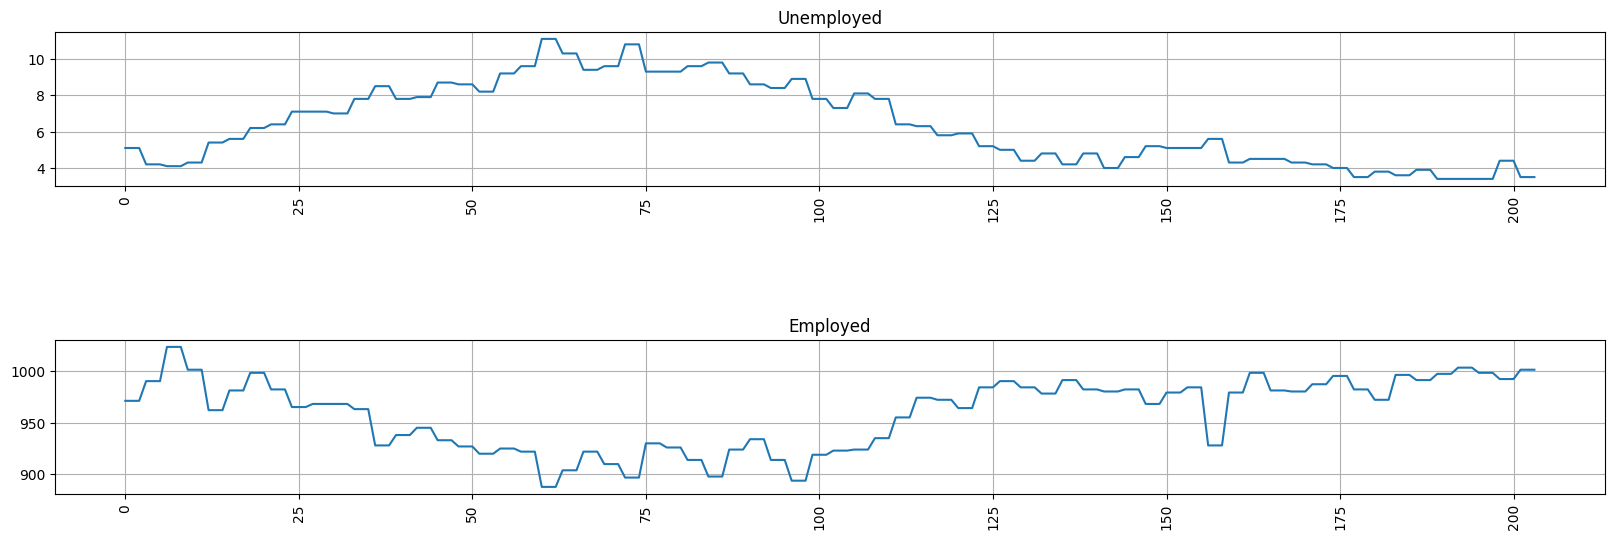

In [102]:
import warnings
warnings.filterwarnings('ignore')
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 6))

ax1.set_title("Unemployed")
ax1.plot(df.unemployeed)
ax1.grid(True)
_=ax1.set_xticklabels(ax1.get_xticklabels(), rotation=90)

plt.subplots_adjust(hspace=1, wspace=0.4)


ax2.set_title("Employed")
ax2.plot(df.employeed)
ax2.grid(True)
_=ax2.set_xticklabels(ax2.get_xticklabels(), rotation=90)

On the following time series values, we can see the formal employment in Slovenia. According to the Wikipedia, Slovenia has 2.1 million people. In the last quarter, there was cca. 1 million employed persons in Slovenia or around 50% with respect to the whole population.  

In [108]:
def quartals(df):
    dates = df["DATE"]
    quarts = []
    for d in dates:
        m = d.month
        y = d.year
        if m in (1,2,3): quarts.append(f"{y}Q1")
        elif m in (4,5,6): quarts.append(f"{y}Q2")
        elif m in (7,8,9): quarts.append(f"{y}Q3")
        else: quarts.append(f"{y}Q4")
    df["Q"] = quarts
    return df
    
df_npl = pd.read_excel("datav2/npl_bank.xlsx")
df_npl.DATE[0].month
df_qrt = quartals(df_npl)
df_qrt # Q
M = df_qrt.merge(df.reset_index(), on="Q")
M.head()

,DATE,NPL,Q,index,unemployeed,employeed,HICP
0,2008-03-31,0.052049,2008Q1,0,5.1,971,6.4
1,2008-03-31,0.052049,2008Q1,1,5.1,971,6.3
2,2008-03-31,0.052049,2008Q1,2,5.1,971,6.6
3,2008-06-30,0.042428,2008Q2,3,4.2,990,6.2
4,2008-06-30,0.042428,2008Q2,4,4.2,990,6.2


# Normalization of the data 

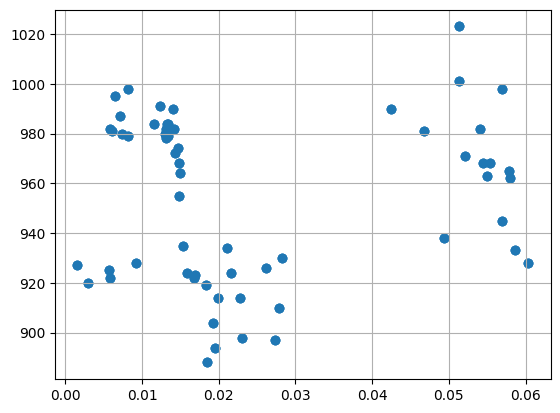

In [110]:
plt.scatter(x=M["NPL"], y=M["employeed"])
plt.grid()

Text(0, 0.5, 'Normalized Employment')

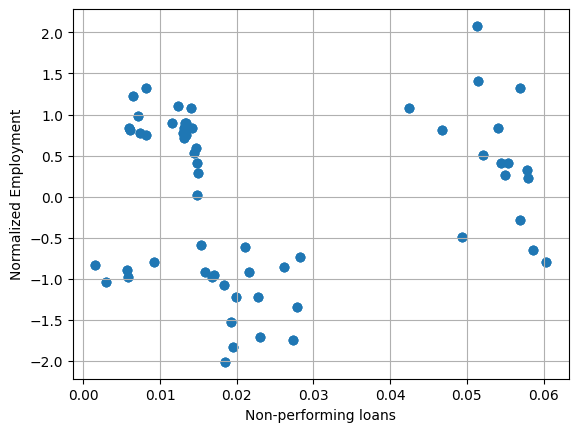

In [112]:
ms = M[["DATE", "Q", "NPL", "employeed"]]
ms["emply_norm"] = (ms["employeed"] - ms["employeed"].mean())/ms["employeed"].std()


plt.scatter(x=ms["NPL"], y=ms["emply_norm"])
plt.grid()
plt.xlabel("Non-performing loans")
plt.ylabel("Normalized Employment")


Text(0, 0.5, 'NPL')

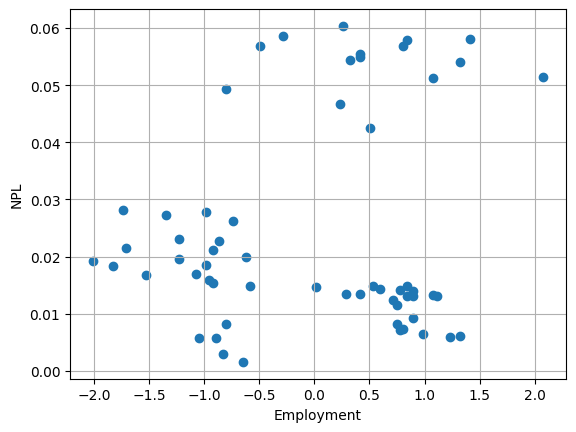

In [113]:
def pair(empl, npl, k, group_function=lambda x : x):
    result = []
    group = []
    for i, e in enumerate(empl):
        try:
            group.append(e)
            if (i+1) % k == 0:
                group = group_function(group)
                n = int((i+1)/k)
                index = n*k
                result.append((group, npl[index]))
                group = []
        except KeyError as e:
            break
    return result

empl = ms["emply_norm"]
npl = ms["NPL"]
result = pair(empl, npl, 3, lambda group : sum(group)/len(group))
result = np.array(result)
plt.scatter(result[:, 0], result[:, 1])
plt.grid()

plt.xlabel("Employment")
plt.ylabel("NPL")

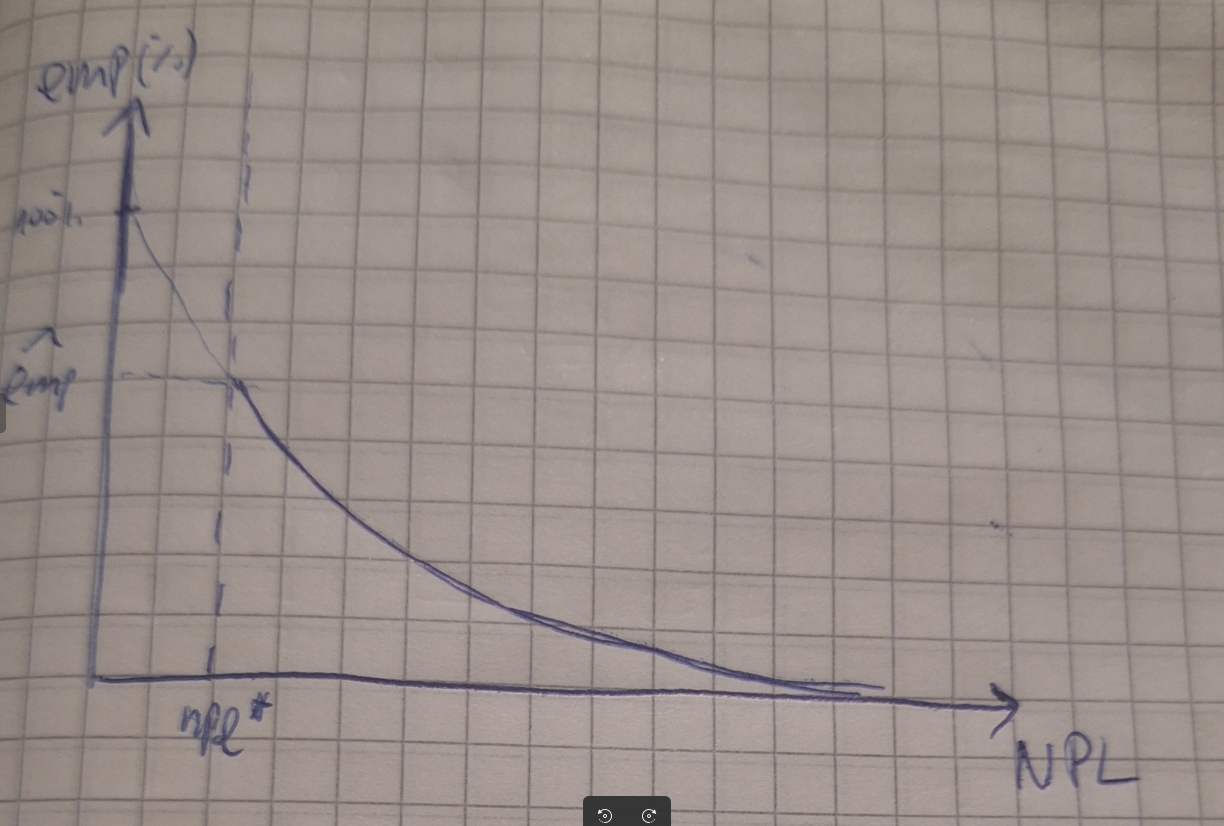

In the figure above we can see the sketch of the most commonly assumed relationship between the NPL and EMP. NPL* is the lowest possible non-performing loan ratio or level under the assumption that some debtor will forget to make regular payments. This assumption is probably true for every bank.   
There are a few possible scenarios why this could take place:

* The debtor has lost their job, he lost his savings and his safety net he will not be able to pay his debt
* Debtor forgot to pay its debt
* The debtor doesn't want to pay the debt, he is running. 
* Bank data collection and background checks are weak and there is a lot of bad debt issued to people who are not employed or
 have poor credit risk and jobs. I call this a safety mechanism.  
* The debtor has the savings or safety net, he is not employed, and he can take the debt, but he will not return it. 





Text(0, 0.5, 'NPL')

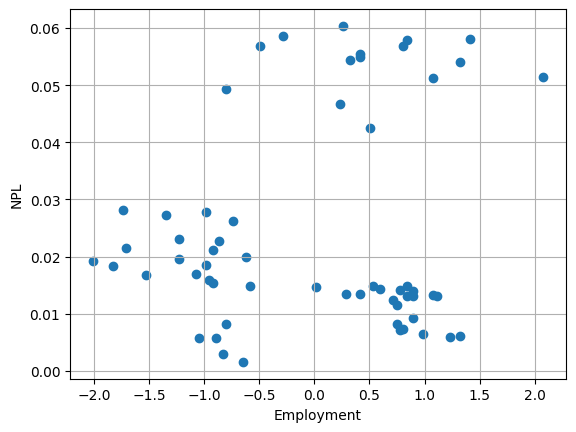

In [114]:
empl = ms["emply_norm"]
npl = ms["NPL"]
result = pair(empl, npl, 3, lambda group : sum(group)/len(group))
result = np.array(result)
plt.scatter(result[:, 0], result[:, 1])
plt.grid()

plt.xlabel("Employment")
plt.ylabel("NPL")

# Inflation data

In [128]:
df_inflation = pd.read_csv("inflation.csv")
df_inflation["DATE"] = pd.to_datetime(df_inflation["DATE"])
df_inflation = quartals(df_inflation)

In [130]:
df_inflation["DATE"]

0     2002-01-31
1     2002-02-28
2     2002-03-31
3     2002-04-30
4     2002-05-31
         ...    
274   2024-11-30
275   2024-12-31
276   2025-01-31
277   2025-02-28
278   2025-03-31
Name: DATE, Length: 279, dtype: datetime64[ns]

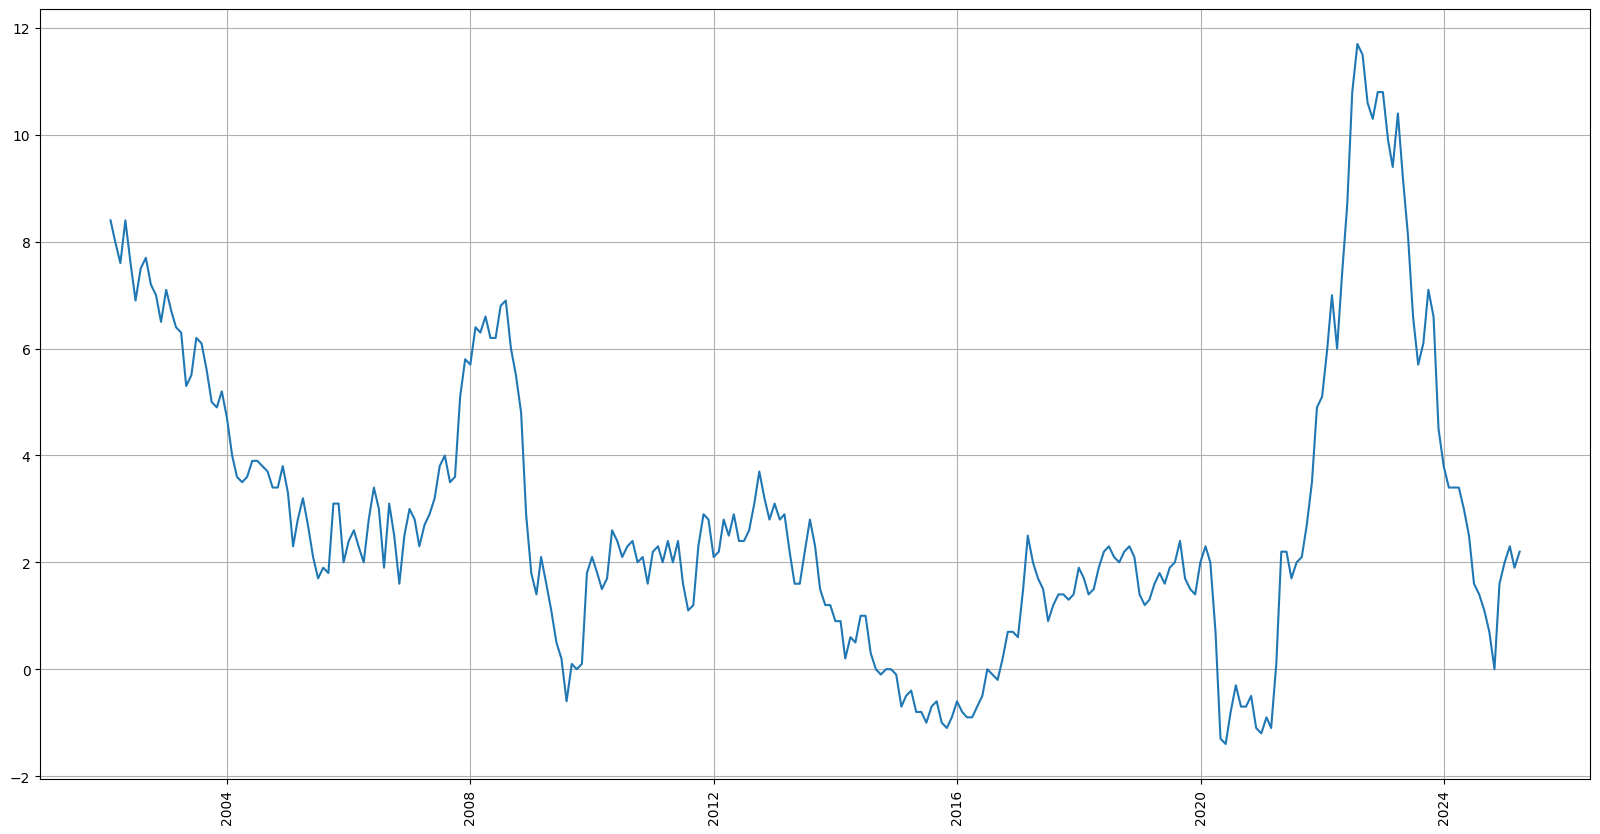

In [135]:
plt.figure(figsize=(20,10))
plt.plot(df_inflation["DATE"], df_inflation["HICP"])
_=plt.xticks(rotation=90)
#_=plt.xticks([i*10 for i in range(30)])
plt.grid(True)

Text(0, 0.5, 'NPL')

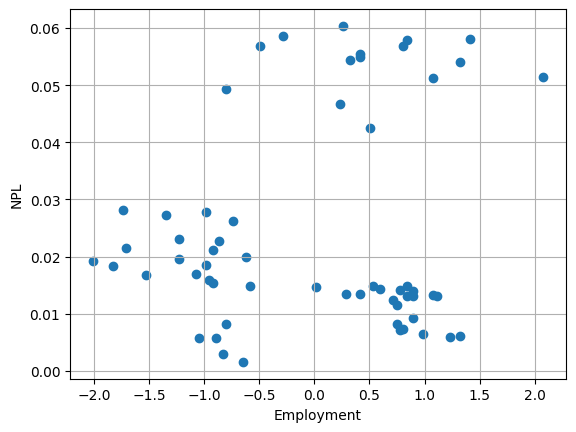

In [136]:
def tripling(empl, npl, k, group_function=lambda x : x):
    result = []
    group = []
    for i, e in enumerate(empl):
        try:
            group.append(e)
            if (i+1) % k == 0:
                group = group_function(group)
                n = int((i+1)/k)
                index = n*k
                result.append((group, npl[index]))
                group = []
        except KeyError as e:
            break
    return result

empl = ms["emply_norm"]
npl = ms["NPL"]
result = pair(empl, npl, 3, lambda group : sum(group)/len(group))
result = np.array(result)
plt.scatter(result[:, 0], result[:, 1])
plt.grid()

plt.xlabel("Employment")
plt.ylabel("NPL")

In [137]:
def quartals(df):
    dates = df["DATE"]
    quarts = []
    for d in dates:
        m = d.month
        y = d.year
        if m in (1,2,3): quarts.append(f"{y}Q1")
        elif m in (4,5,6): quarts.append(f"{y}Q2")
        elif m in (7,8,9): quarts.append(f"{y}Q3")
        else: quarts.append(f"{y}Q4")
    df["Q"] = quarts
    return df

df_inflation["DATE"] = pd.to_datetime(df_inflation["DATE"])
df_inflation = quartals(df_inflation)
ks = ms.merge(df_inflation, on="Q")
ks

,DATE_x,Q,NPL,employeed,emply_norm,DATE_y,HICP
0,2008-03-31,2008Q1,0.052049,971,0.503477,2008-01-31,6.4
1,2008-03-31,2008Q1,0.052049,971,0.503477,2008-02-29,6.3
2,2008-03-31,2008Q1,0.052049,971,0.503477,2008-03-31,6.6
3,2008-03-31,2008Q1,0.052049,971,0.503477,2008-01-31,6.4
4,2008-03-31,2008Q1,0.052049,971,0.503477,2008-02-29,6.3
...,...,...,...,...,...,...,...
535,2022-12-31,2022Q4,0.005884,982,0.836771,2022-11-30,10.8
536,2022-12-31,2022Q4,0.005884,982,0.836771,2022-12-31,10.8
537,2022-12-31,2022Q4,0.005884,982,0.836771,2022-10-31,10.3
538,2022-12-31,2022Q4,0.005884,982,0.836771,2022-11-30,10.8


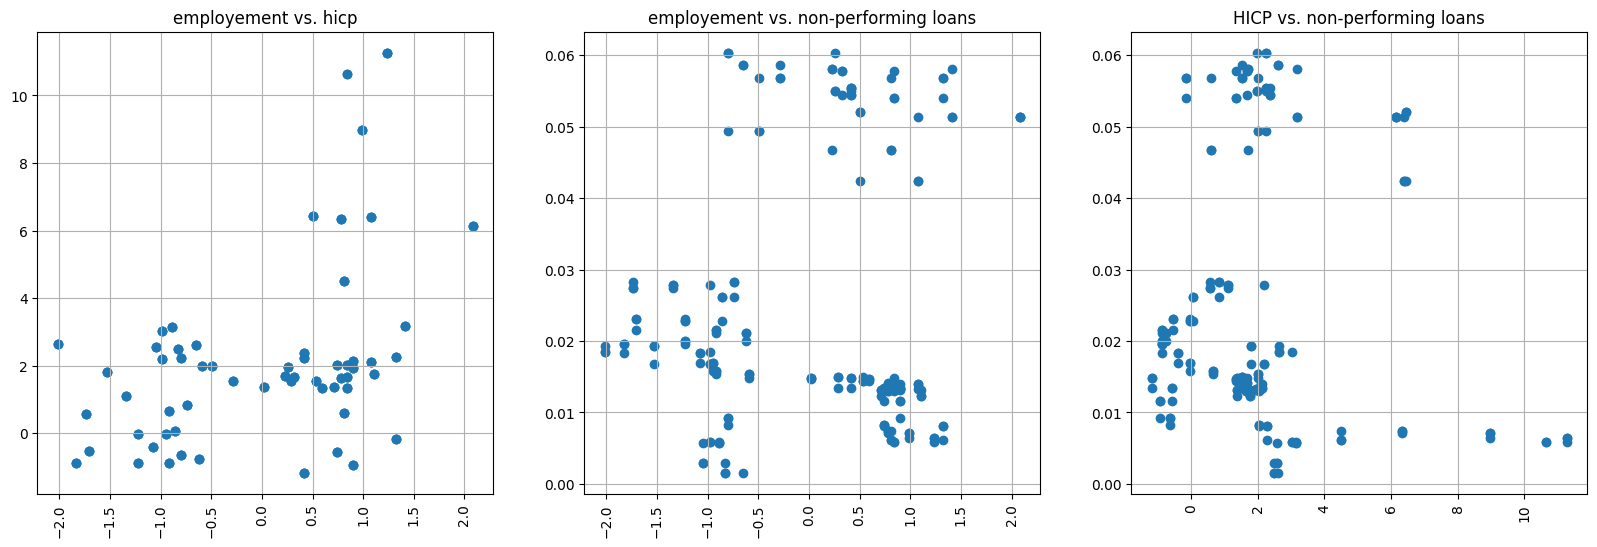

In [138]:
def tripling(empl, hicp, npl, k, group_function=lambda x : x):
    result = []
    group_empl = []
    group_inf  = []
    N = len(hicp)
    for i in range(N):
        try:
            group_empl.append(empl[i])
            group_inf.append(hicp[i])
            if (i+1) % k == 0:
                group_empl = group_function(group_empl)
                group_inf = group_function(group_inf)
                n = int((i+1)/k)
                index = n*k
                result.append((group_empl, group_inf, npl[index]))
                group_empl = []
                group_inf  = []
        except KeyError as e:
            break
    return np.array(result)

empl = ks["emply_norm"]
npl  = ks["NPL"]
hicp = ks["HICP"]

result = tripling(empl, hicp, npl, 3, lambda group : sum(group)/len(group))


fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 6))

ax1.set_title("employement vs. hicp")
ax1.scatter(result[:, 0], result[:, 1])
ax1.grid()
_=ax1.set_xticklabels(ax1.get_xticklabels(), rotation=90)

ax2.set_title("employement vs. non-performing loans")
ax2.scatter(result[:, 0], result[:, 2])
ax2.grid()
_=ax2.set_xticklabels(ax2.get_xticklabels(), rotation=90)


ax3.set_title("HICP vs. non-performing loans")
ax3.scatter(result[:, 1], result[:, 2])
ax3.grid()
_=ax3.set_xticklabels(ax3.get_xticklabels(), rotation=90)


## Relationship 

**Businessman, employee relationship.**: The average wage increase is typically the linear process with a small delta increase under inflation intervention  

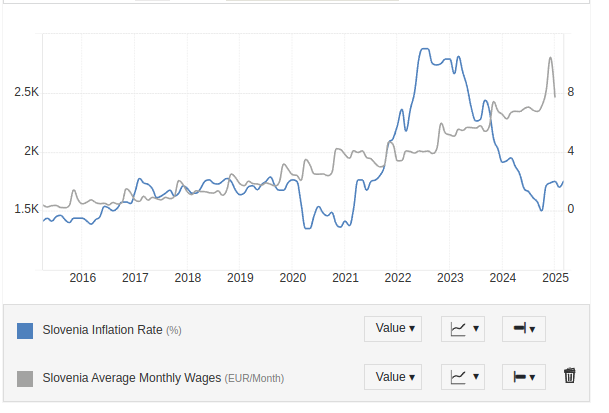

In the upper figure, we can see the relationship between the inflation rate and wage trend. We can see a small mean increase under a small time lag under inflation intervention.  

# Linear regression

Slope: 1.064, Intercept: 2.024
Slope: 0.002, Intercept: 0.025
Slope: -0.000, Intercept: 0.025


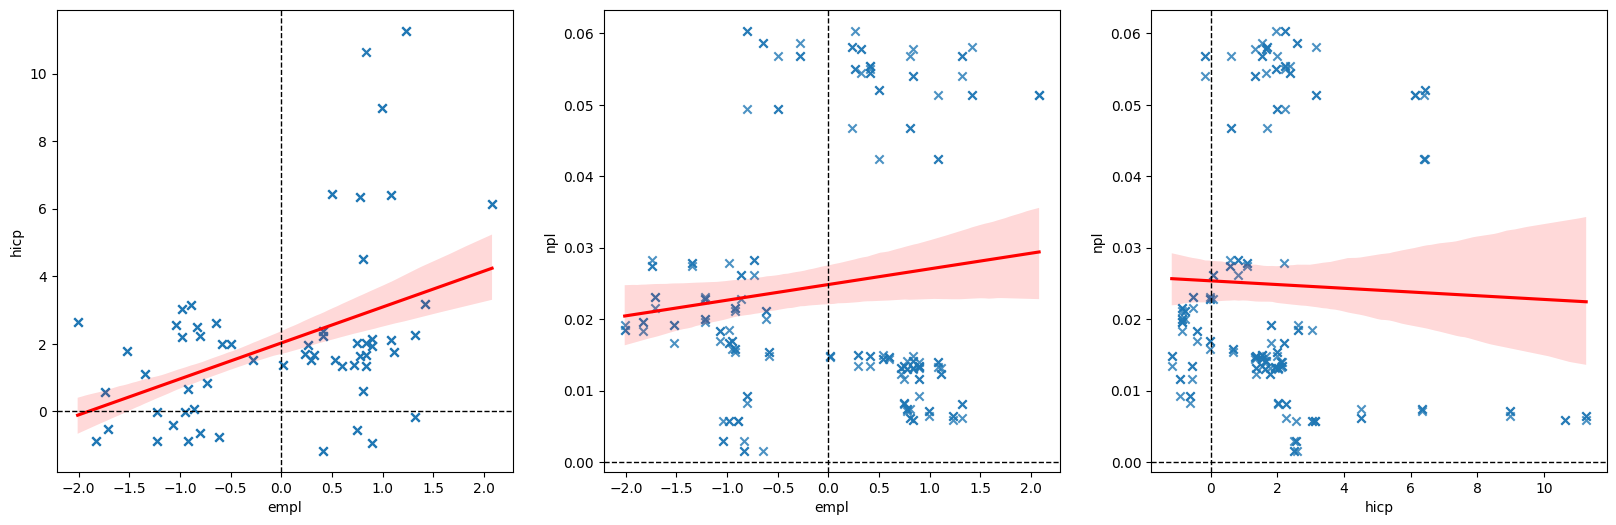

In [139]:
import scipy.stats

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 6))
df = pd.DataFrame(result, columns=["empl", "hicp", "npl"])

p1 = sns.regplot(x="empl", y="hicp", data=df, ax=ax1, marker="x", line_kws=dict(color="r"))
ax1.axhline(y=0, color='black', linestyle='--', linewidth=1)
ax1.axvline(x=0, color='black', linestyle='--', linewidth=1)

p2 = sns.regplot(x="empl", y="npl", data=df, ax=ax2, marker="x", line_kws=dict(color="r"))
ax2.axhline(y=0, color='black', linestyle='--', linewidth=1)
ax2.axvline(x=0, color='black', linestyle='--', linewidth=1)

p3 = sns.regplot(x="hicp", y="npl", data=df, ax=ax3, marker="x", line_kws=dict(color="r"))
ax3.axhline(y=0, color='black', linestyle='--', linewidth=1)
ax3.axvline(x=0, color='black', linestyle='--', linewidth=1)


def report(p):
    line = p.get_lines()[0]
    slope, intercept, r_value, _, _ = scipy.stats.linregress(
        x=line.get_xdata(),
        y=line.get_ydata()
    )
    print(f"Slope: {slope:.3f}, Intercept: {intercept:.3f}")

report(p1)
report(p2)
report(p3)

Obviously, here data is not linear and using the regression is questionable. Data needs to be transformed and tested for nonlinearity. 
On the next chunk, I'm using the Ridge regression where I'm fitting the employment data and inflation data on the NPL.

The next thing I want to do is the testing of the trained model. In the simplified scenario, I will split the time series in such a way that 
the test data will be in the future. If one wants to apply the 

Analyzed time-series data should follow the statinarity property which states that the series should have a constant mean. 

In [140]:
from sklearn import linear_model
from sklearn.model_selection import KFold

def neg(X, index_start, index_end):
    Y = []
    for i in range(len(X)):
        if not (i >= index_start and i < index_end):
            x = X[i]
            Y.append(x)
    return np.array(Y)

def kfolds(X, M):
    N = len(X)
    M = 10
    split_num = int(N/M)
    splits = []
    for i in range(1, split_num+1):
        index_start = (i-1)*M
        index_end   = i*M 
        test_fold = X[index_start:index_end]
        train_fold = neg(X, index_start, index_end)
        split = (train_fold, test_fold)
        splits.append(split)
    return splits

splits = kfolds(result, 10)
for i, (X_train, X_test) in enumerate(splits):
    model = linear_model.Ridge(alpha=0.5)
    xt = X_train[:,0:2]
    yt = X_train[:,2]
    model.fit(xt, yt)
    xt = X_test[:,0:2]
    y_true = X_test[:,2]
    y_pred = model.predict(xt)
    L = (y_pred - y_true).sum()/len(xt)
    print(f"split = {i} -> {L}")


split = 0 -> -0.029882008871298698
split = 1 -> -0.029394454236044254
split = 2 -> -0.031195167385240065
split = 3 -> -0.03292210369353858
split = 4 -> -0.018161422070184546
split = 5 -> 0.017659252609935117
split = 6 -> 0.0003332205637004464
split = 7 -> -0.0058018999566927755
split = 8 -> 0.0007502316177963045
split = 9 -> 0.004309673376226014
split = 10 -> 0.00783432067929829
split = 11 -> 0.012355466392272736
split = 12 -> 0.014860262800002928
split = 13 -> 0.016824407440946397
split = 14 -> 0.015823676371654417
split = 15 -> 0.020203752952511998
split = 16 -> 0.02146769575057253
